# *This file allows to generate all plots necessary for figures*

# **Useful packages and functions**

In [1]:
using DifferentialEquations, Plots, Polynomials, LaTeXStrings, ColorSchemes, DelimitedFiles, DataFrames
using Statistics, StatsPlots, Random, ProgressMeter, Printf, LinearAlgebra, Plots.PlotMeasures
include("DA_kinetics.jl") # Loading of DA kinetics of gating variables
include("DA_models.jl") # Loading of DA model
include("DA_utils.jl"); # Loading of some utils functions

# **Global variables**

In [2]:
# Definition of simulation time (in ms)
const Tfinal = 1000000
const tspan  = (0.0, Tfinal)
tt = 0. : 0.01 : Tfinal
tt_rand = 0. : 1 : Tfinal
tt_plot = 0. : 0.01 : 20000.

# Definition of reversal potential values (in mV), [Mg] and membrane capacitance
const VNa     = 60. # Sodium reversal potential
const VK      = -90. # Potassium reversal potential
const VCa     = 50. # Calcium reversal potential
const VH      = -29. # H reversal potential
const VLNS    = -65. # Leak reversal potential
const EPacemaker = 4.2732015978991615 # Reversal potential of pacemaking channels

const C       = 1. # Membrane capacitance
const fCa     = 0.018 # Fraction of unbuffered free calcium
const ICapmax = 11 # Maximum calcium pump current
const F       = 96520 # Faraday constant in ms*µA/mmol (and taking cm³=mL)
const d       = 15 # Soma diameter in cm
const L       = 25 # Soma length

# Definition of voltage range for the DICs
const Vmin = -100 
const Vmax = 50
const Vrange = range(Vmin, stop=Vmax, step=0.0154640);

In [3]:
# Modifying backend GR attributes
gr(guidefontsize=25, tickfontsize=15, legendfontsize=12, margin=5Plots.mm, grid=false)
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1)
myGray = RGBA(150/255, 150/255, 150/255, 1)
myLightBlue = RGBA(127/255, 154/255, 209/255, 1);
default(fmt = :png);

In [4]:
# Define a struct (optional, but useful if you need parameters)
struct NoisyFunction
    amplitude::Float64  # amplitude of the noise
end

# Overload the () operator to make the struct callable
function (nf::NoisyFunction)(x::Float64)
    noise = nf.amplitude * randn()  # Generate Gaussian noise (mean 0, std 1)
    return noise  # Example function with noise
end

function condition(u,t,integrator) # Event when event_f(u,t) == 0
  (u[1]- (-20.))
end

function affect!(integrator)
end

cb = ContinuousCallback(condition, affect!, nothing, save_positions = (true, false));

In [12]:
# Parameter vector for simulations
n = 50
NoiseIntensities = range(0, 20, length=n) 

0.0:0.40816326530612246:20.0

# **Figure 5**

# Simu noisy model instantaneous Na Kd only

In [5]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 0. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 0. # A-type potassium current maximal conductance
gKERG      = 0. # ERG current maximal conductance
gKSK       = 0. # SK current maximal conductance
gH         = 0. # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0. # Leak calcium current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance

# Parameter vector for simulations
n = 50
NoiseIntensities = range(0, 20, length=n) 

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]

CV_ISI_NaKd = zeros(n)

for (i, NoiseIntensity) in enumerate(NoiseIntensities)
    display(i)
    # Parameter vector for simulations
    p = (NoisyFunction(NoiseIntensity), gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

    # Simulation
    prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
    sol_NaKdi = solve(prob; maxiters=1e9, callback=cb, verbose=false,
                   save_everystep=false,save_start=false,save_end=false)

    # Extracting ISIs
    ISIs_NaKdi = zeros(length(sol_NaKdi.t)-1)
    for i = 1 : length(sol_NaKdi.t) - 1
        ISIs_NaKdi[i] = sol_NaKdi.t[i+1] - sol_NaKdi.t[i]
    end

    filename = "./data/ISIs_NaKd$(i).dat"
    writedlm(filename, ISIs_NaKdi)

    CV_ISI_NaKd[i] = std(ISIs_NaKdi) / mean(ISIs_NaKdi)
end

writedlm("./data/CV_ISI_NaKd.dat", CV_ISI_NaKd);

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

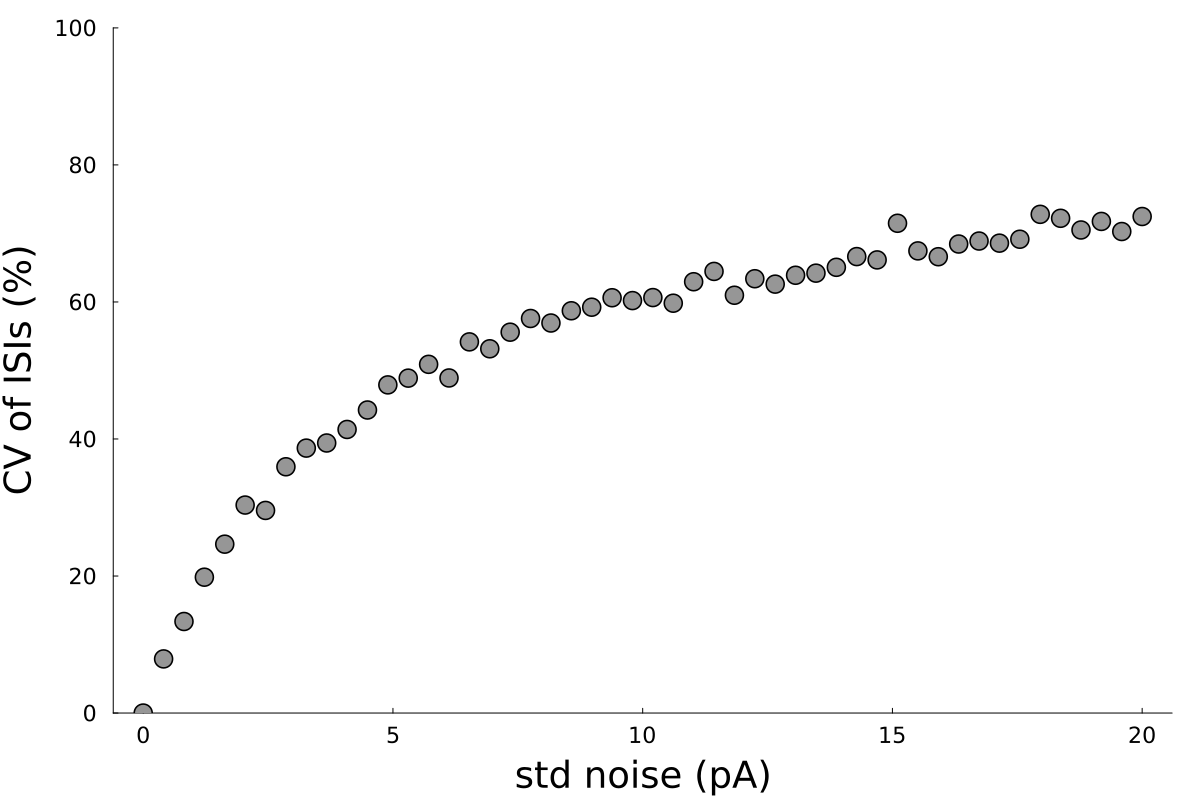

In [13]:
CV_ISI_NaKd = readdlm("./data/CV_ISI_NaKd.dat")
NoiseIntensities = range(0, 20, length=n) 
CV_noise = plot(NoiseIntensities, 100*CV_ISI_NaKd, seriestype=:scatter, legend=false, linewidth=2.5, 
          color=myGray, size=(1200, 800), markersize=10, margins=20Plots.px)
ylabel!("CV of ISIs (%)")
xlabel!("std noise (pA)")
ylims!((0, 100))
display(CV_noise)

# Simu noisy model instantaneous with SK

In [7]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 1. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 0. # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0.3 # SK current maximal conductance
gH         = 0. # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance

# Parameter vector for simulations
n = 50
NoiseIntensities = range(0, 20, length=n) 

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]

CV_ISI_SK = zeros(n)

for (i, NoiseIntensity) in enumerate(NoiseIntensities)
    display(i)
    # Parameter vector for simulations
    p = (NoisyFunction(NoiseIntensity), gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

    # Simulation
    prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
    sol_SKi = solve(prob; maxiters=1e9, callback=cb, verbose=false,
                   save_everystep=false,save_start=false,save_end=false)

    # Extracting ISIs
    ISIs_SKi = zeros(length(sol_SKi.t)-1)
    for i = 1 : length(sol_SKi.t) - 1
        ISIs_SKi[i] = sol_SKi.t[i+1] - sol_SKi.t[i]
    end

    filename = "./data/ISIs_SK$(i).dat"
    writedlm(filename, ISIs_SKi)

    CV_ISI_SK[i] = std(ISIs_SKi) / mean(ISIs_SKi)
end

writedlm("./data/CV_ISI_SK.dat", CV_ISI_SK);

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

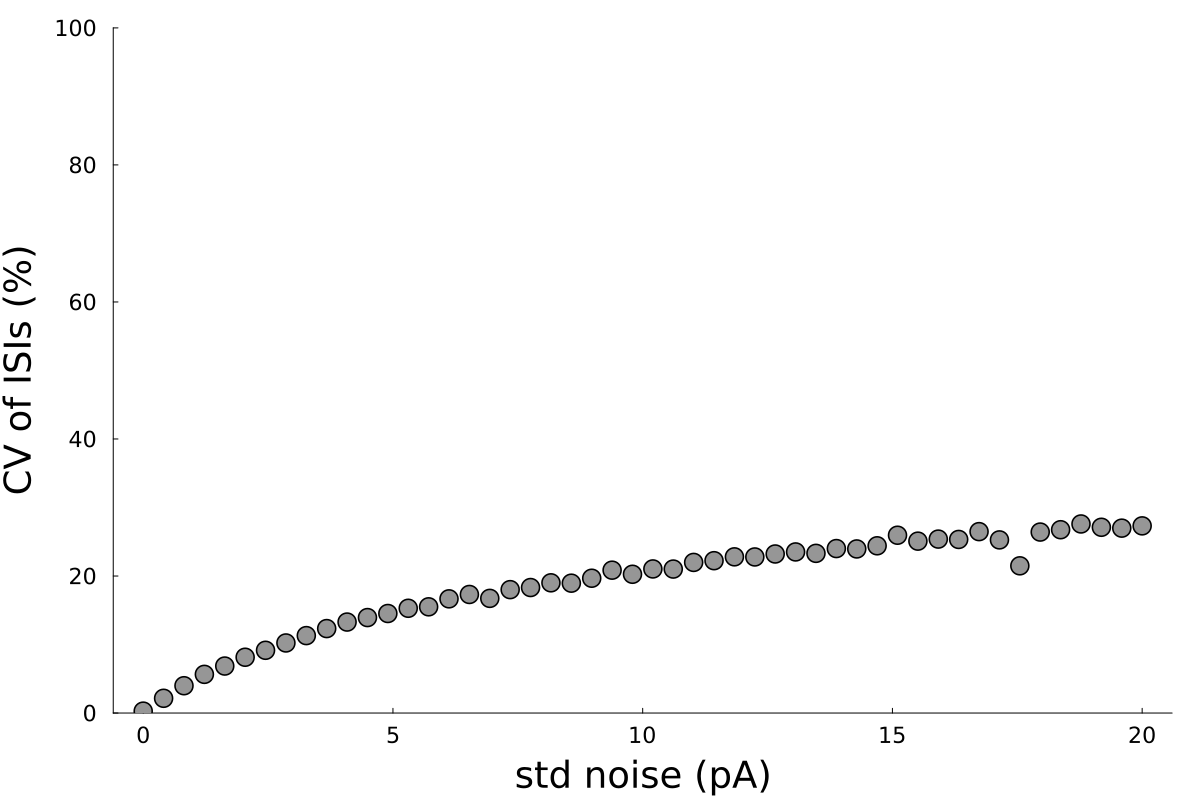

In [14]:
CV_ISI_SK = readdlm("./data/CV_ISI_SK.dat")
NoiseIntensities = range(0, 20, length=n) 
CV_noise = plot(NoiseIntensities, 100*CV_ISI_SK, seriestype=:scatter, legend=false, linewidth=2.5, 
          color=myGray, size=(1200, 800), markersize=10, margins=20Plots.px)
ylabel!("CV of ISIs (%)")
xlabel!("std noise (pA)")
ylims!((0, 100))
display(CV_noise)

# Simu noisy model instantaneous with H

In [9]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 0. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 0. # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0. # SK current maximal conductance
gH         = 0.078 # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance

# Parameter vector for simulations
n = 50
NoiseIntensities = range(0, 20, length=n) 

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]

CV_ISI_H = zeros(n)

for (i, NoiseIntensity) in enumerate(NoiseIntensities)
    display(i)
    # Parameter vector for simulations
    p = (NoisyFunction(NoiseIntensity), gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

    # Simulation
    prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
    sol_Hi = solve(prob; maxiters=1e9, callback=cb, verbose=false,
                   save_everystep=false,save_start=false,save_end=false)

    # Extracting ISIs
    ISIs_Hi = zeros(length(sol_Hi.t)-1)
    for i = 1 : length(sol_Hi.t) - 1
        ISIs_Hi[i] = sol_Hi.t[i+1] - sol_Hi.t[i]
    end

    filename = "./data/ISIs_H$(i).dat"
    writedlm(filename, ISIs_Hi)

    CV_ISI_H[i] = std(ISIs_Hi) / mean(ISIs_Hi)
end

writedlm("./data/CV_ISI_H.dat", CV_ISI_H);

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

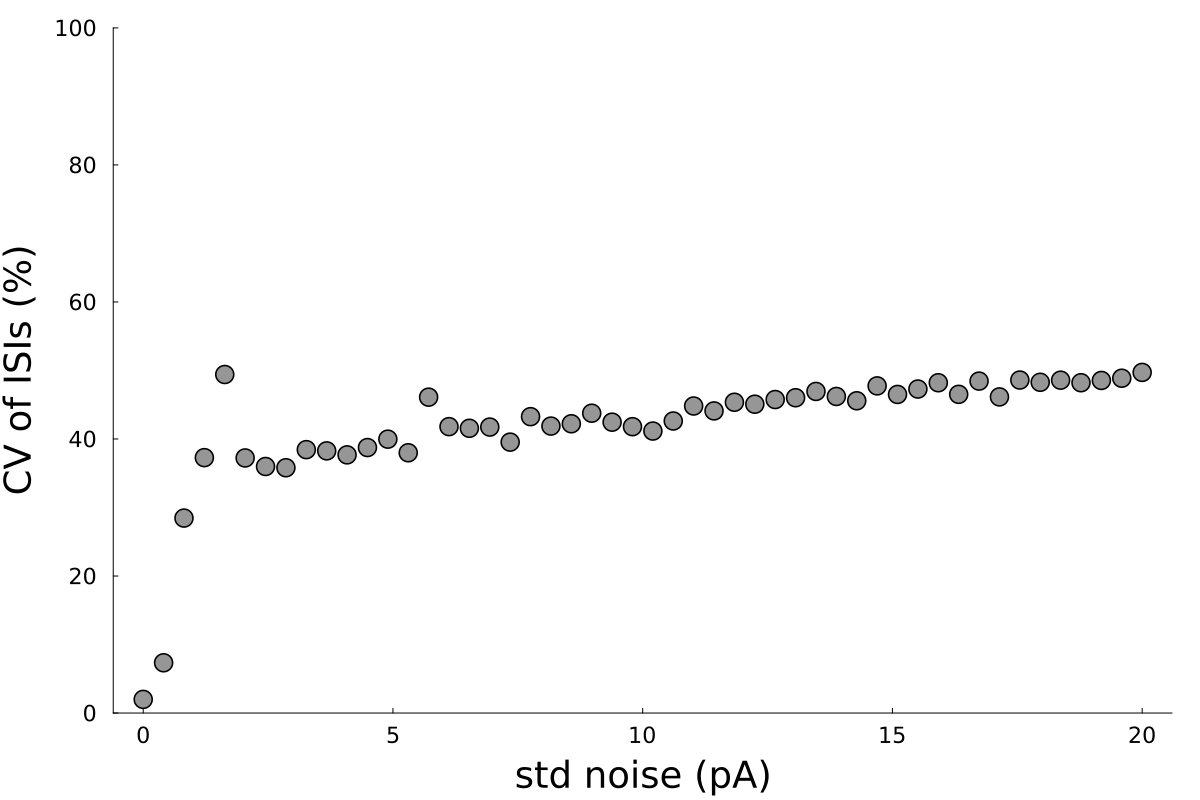

In [15]:
CV_ISI_H = readdlm("./data/CV_ISI_H.dat")
NoiseIntensities = range(0, 20, length=n) 
CV_noise = plot(NoiseIntensities, 100*CV_ISI_H, seriestype=:scatter, legend=false, linewidth=2.5, 
          color=myGray, size=(1200, 800), markersize=10, margins=20Plots.px)
ylabel!("CV of ISIs (%)")
xlabel!("std noise (pA)")
ylims!((0, 100))
display(CV_noise)

# Simu noisy model instantaneous with H and A

In [11]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 0. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 1.68 # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0. # SK current maximal conductance
gH         = 0.078 # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance

# Parameter vector for simulations
n = 50
NoiseIntensities = range(0, 20, length=n) 

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]

CV_ISI_HA = zeros(n)

for (i, NoiseIntensity) in enumerate(NoiseIntensities)
    display(i)
    # Parameter vector for simulations
    p = (NoisyFunction(NoiseIntensity), gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

    # Simulation
    prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
    sol_HAi = solve(prob; maxiters=1e9, callback=cb, verbose=false,
                   save_everystep=false,save_start=false,save_end=false)

    # Extracting ISIs
    ISIs_HAi = zeros(length(sol_HAi.t)-1)
    for i = 1 : length(sol_HAi.t) - 1
        ISIs_HAi[i] = sol_HAi.t[i+1] - sol_HAi.t[i]
    end

    filename = "./data/ISIs_HA$(i).dat"
    writedlm(filename, ISIs_HAi)

    CV_ISI_HA[i] = std(ISIs_HAi) / mean(ISIs_HAi)
end

writedlm("./data/CV_ISI_HA.dat", CV_ISI_HA);

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

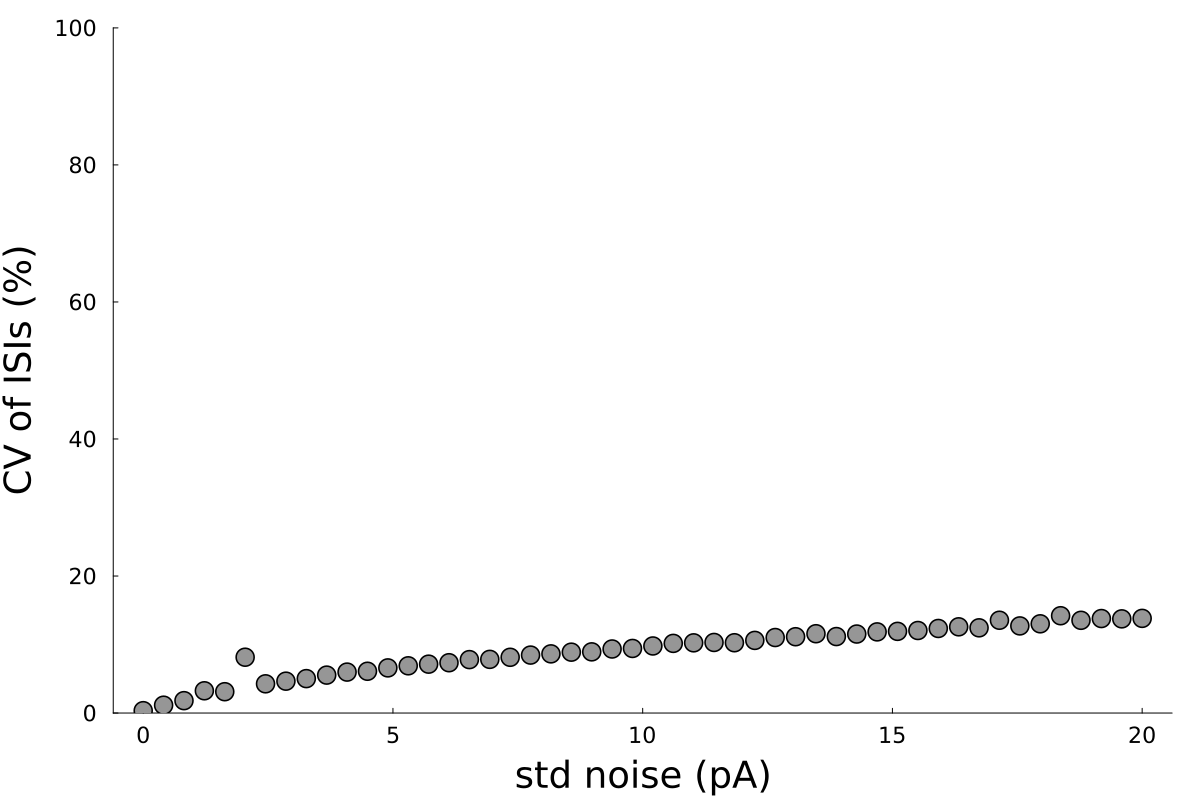

In [16]:
CV_ISI_HA = readdlm("./data/CV_ISI_HA.dat")
NoiseIntensities = range(0, 20, length=n) 
CV_noise = plot(NoiseIntensities, 100*CV_ISI_HA, seriestype=:scatter, legend=false, linewidth=2.5, 
          color=myGray, size=(1200, 800), markersize=10, margins=20Plots.px)
ylabel!("CV of ISIs (%)")
xlabel!("std noise (pA)")
ylims!((0, 100))
display(CV_noise)

# Simu noisy model instantaneous with H and SK

In [13]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 1. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 0. # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0.3 # SK current maximal conductance
gH         = 0.078 # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance

# Parameter vector for simulations
n = 50
NoiseIntensities = range(0, 20, length=n) 

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]

CV_ISI_HSK = zeros(n)

for (i, NoiseIntensity) in enumerate(NoiseIntensities)
    display(i)
    # Parameter vector for simulations
    p = (NoisyFunction(NoiseIntensity), gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

    # Simulation
    prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
    sol_HSKi = solve(prob; maxiters=1e9, callback=cb, verbose=false,
                   save_everystep=false,save_start=false,save_end=false)

    # Extracting ISIs
    ISIs_HSKi = zeros(length(sol_HSKi.t)-1)
    for i = 1 : length(sol_HSKi.t) - 1
        ISIs_HSKi[i] = sol_HSKi.t[i+1] - sol_HSKi.t[i]
    end

    filename = "./data/ISIs_HSK$(i).dat"
    writedlm(filename, ISIs_HSKi)

    CV_ISI_HSK[i] = std(ISIs_HSKi) / mean(ISIs_HSKi)
end

writedlm("./data/CV_ISI_HSK.dat", CV_ISI_HSK);

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

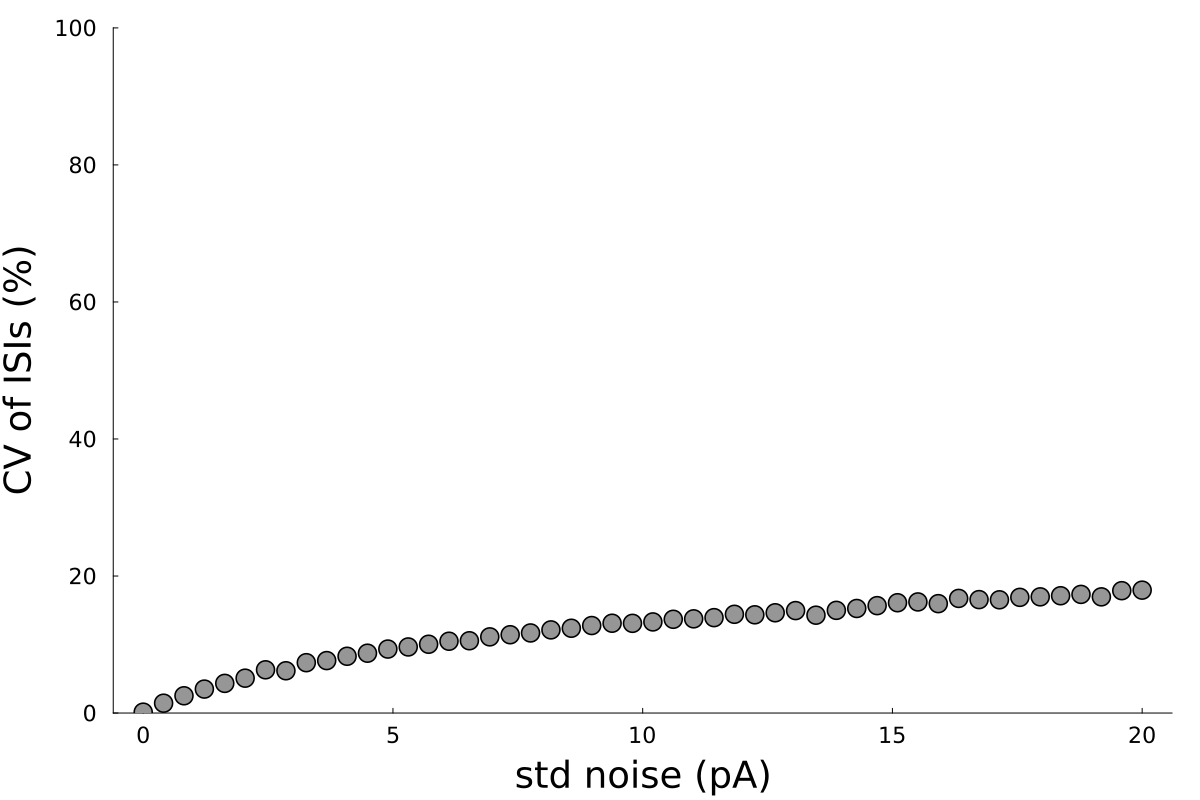

In [17]:
CV_ISI_HSK = readdlm("./data/CV_ISI_HSK.dat")
NoiseIntensities = range(0, 20, length=n) 
CV_noise = plot(NoiseIntensities, 100*CV_ISI_HSK, seriestype=:scatter, legend=false, linewidth=2.5, 
          color=myGray, size=(1200, 800), markersize=10, margins=20Plots.px)
ylabel!("CV of ISIs (%)")
xlabel!("std noise (pA)")
ylims!((0, 100))
display(CV_noise)

# Simu noisy model instantaneous with all

In [15]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 1. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 1.68 # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0.3 # SK current maximal conductance
gH         = 0.078 # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance

# Parameter vector for simulations
n = 50
NoiseIntensities = range(0, 20, length=n) 

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]

CV_ISI_AHSK = zeros(n)

for (i, NoiseIntensity) in enumerate(NoiseIntensities)
    display(i)
    # Parameter vector for simulations
    p = (NoisyFunction(NoiseIntensity), gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

    # Simulation
    prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
    sol_AHSKi = solve(prob; maxiters=1e9, callback=cb, verbose=false,
                   save_everystep=false,save_start=false,save_end=false)

    # Extracting ISIs
    ISIs_AHSKi = zeros(length(sol_AHSKi.t)-1)
    for i = 1 : length(sol_AHSKi.t) - 1
        ISIs_AHSKi[i] = sol_AHSKi.t[i+1] - sol_AHSKi.t[i]
    end

    filename = "./data/ISIs_AHSK$(i).dat"
    writedlm(filename, ISIs_AHSKi)

    CV_ISI_AHSK[i] = std(ISIs_AHSKi) / mean(ISIs_AHSKi)
end

writedlm("./data/CV_ISI_AHSK.dat", CV_ISI_AHSK);

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

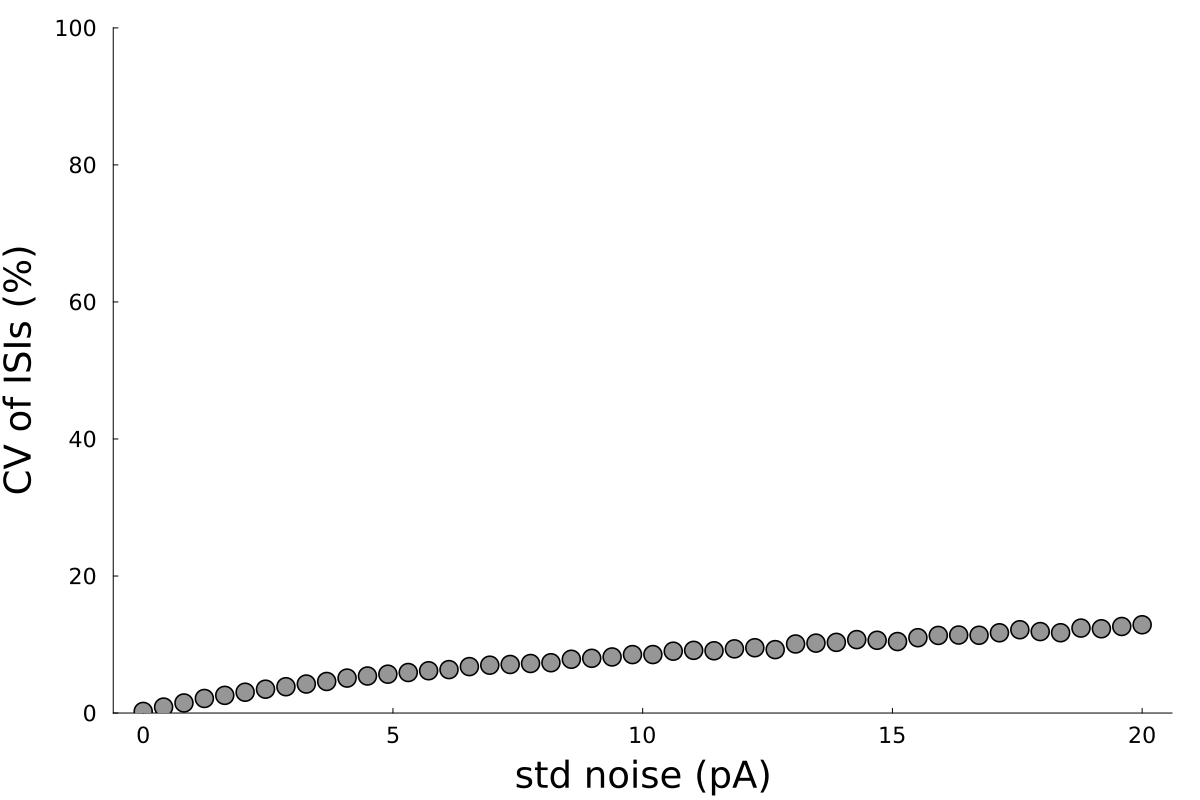

In [18]:
CV_ISI_AHSK = readdlm("./data/CV_ISI_AHSK.dat")
NoiseIntensities = range(0, 20, length=n) 
CV_noise = plot(NoiseIntensities, 100*CV_ISI_AHSK, seriestype=:scatter, legend=false, linewidth=2.5, 
          color=myGray, size=(1200, 800), markersize=10, margins=20Plots.px)
ylabel!("CV of ISIs (%)")
xlabel!("std noise (pA)")
ylims!((0, 100))
display(CV_noise)

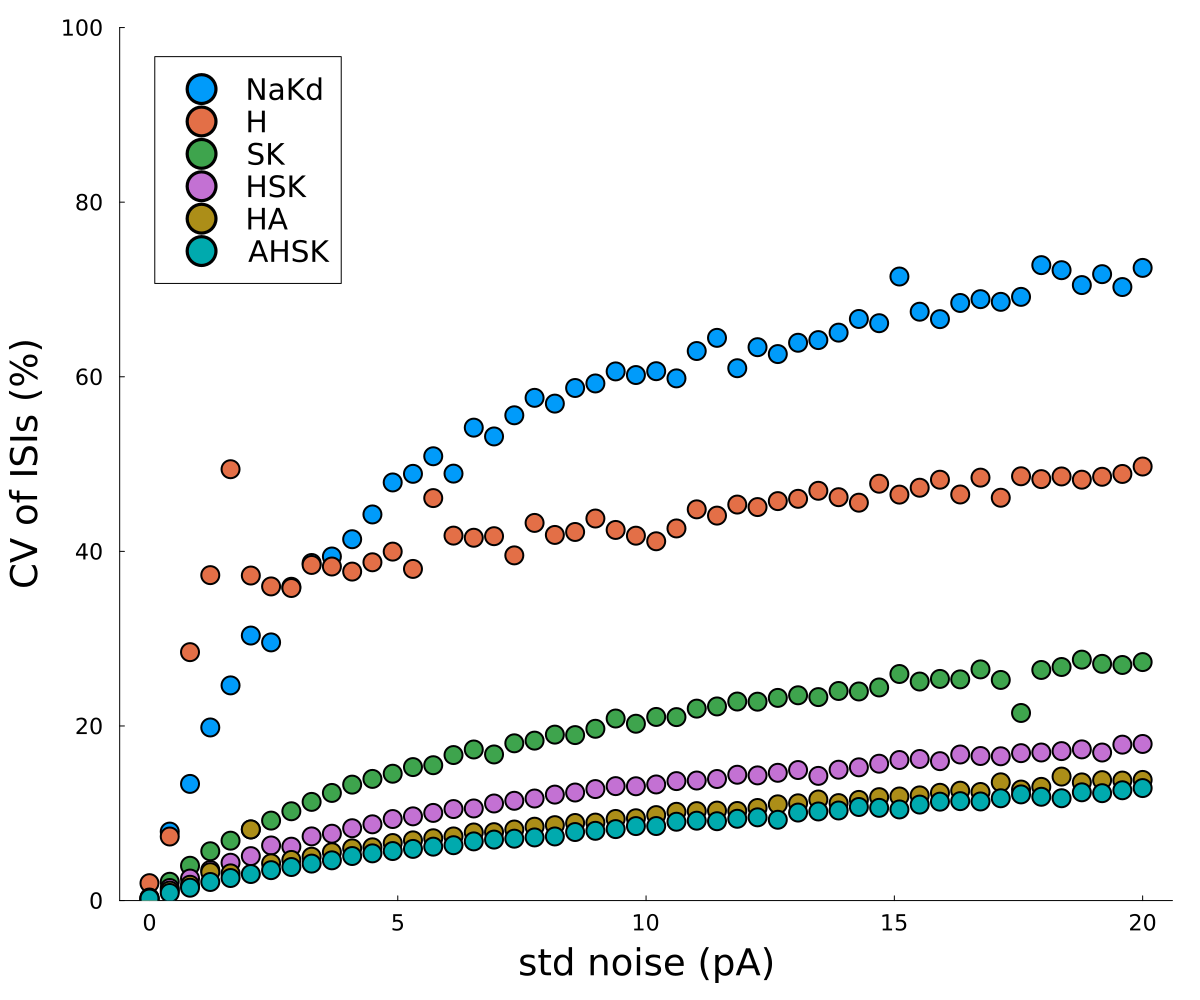

In [20]:
CV_noise = plot(NoiseIntensities, 100*CV_ISI_NaKd, seriestype=:scatter, label="NaKd", markersize=10,
     legend=:topleft, size=(1200, 1000), legendfontsize=20)
plot!(NoiseIntensities, 100*CV_ISI_H, seriestype=:scatter, label="H", markersize=10)
plot!(NoiseIntensities, 100*CV_ISI_SK, seriestype=:scatter, label="SK", markersize=10)
plot!(NoiseIntensities, 100*CV_ISI_HSK, seriestype=:scatter, label="HSK", markersize=10)
plot!(NoiseIntensities, 100*CV_ISI_HA, seriestype=:scatter, label="HA", markersize=10)
plot!(NoiseIntensities, 100*CV_ISI_AHSK, seriestype=:scatter, label="AHSK", markersize=10)
ylabel!("CV of ISIs (%)")
xlabel!("std noise (pA)")
ylims!((0, 100))
# savefig(CV_noise, "./figures/fig5_CVs.pdf")
# savefig(CV_noise, "./figures/fig5_CVs.svg")